In [58]:
import os
import torch
import pandas as pd
import numpy as np
import tensorflow as tf
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.utils import make_grid
from torchsummary import summary
from torchvision import transforms
import torch.nn.functional as F
import time
import os
import copy
import torch.optim as optim
from torch.optim import lr_scheduler


# load pretrained network

load and store models

In [2]:
# dir(models)

alexnet = models.alexnet(weights="IMAGENET1K_V1")
efficientnet = models.efficientnet_b7(weights="IMAGENET1K_V1")
vgg_19 = models.vgg19(weights='IMAGENET1K_V1')
# inception_v3 = models.inception_v3(weights="IMAGENET1K_V1")
# resnet = models.resnet50(weights="IMAGENET1K_V2")

# model = selected_models['resnet']
# [model.state_dict()[key].shape for key in model.state_dict().keys()]

selected_models = {'alexnet':alexnet, 'efficientnet_b7':efficientnet, 'vgg_19':vgg_19}


# Modifying NN

In [3]:
for key in selected_models.keys():
    model = selected_models[key]
    for param in selected_models[key].parameters():
        param.requires_grad = False
    last_layer = [key for key in model.state_dict().keys()][-2]
    last_layer_size = model.state_dict()[last_layer].shape[-1]
    selected_models[key].classifier = nn.Sequential(*list(model.classifier)[:-1], nn.Linear(last_layer_size, 15))

# load data

In [4]:
class_names = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'cricket',
    5: 'football',
    6: 'gymnastics',
    7: 'hockey',
    8: 'swimming',
    9: 'table_tennis',
    10: 'tennis',
    11: 'volleyball',
    12: 'weight_lifting',
    13: 'wrestling',
    14: 'wwe'
}


def get_key(val):
    for key, value in labels.items():
        if val == value:
            return key
 
    return False

In [5]:
preprocess_image = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225])
])

In [6]:
df = pd.read_csv("./data/data.csv") # path to images
y = F.one_hot(torch.as_tensor(df['label'].values), num_classes=15)
image_paths = df['path']
images = []

for path in image_paths:
    try:
        img = Image.open(path)
        images.append(preprocess_image(img.convert('RGB')))
    except Exception as e:
        print(f'image {path} cannot be loaded')

X = torch.stack(images)
print(X.shape)

image .\data\images\table_tennis\00000533.ashx cannot be loaded
image .\data\images\table_tennis\00000726-checkpoint.jpg cannot be loaded
image .\data\images\table_tennis\00000744-checkpoint.jpg cannot be loaded
image .\data\images\table_tennis\00000761-checkpoint.jpg cannot be loaded
image .\data\images\table_tennis\00000765-checkpoint.jpg cannot be loaded
image .\data\images\table_tennis\00000768-checkpoint.jpg cannot be loaded
image .\data\images\table_tennis\00000778-checkpoint.jpg cannot be loaded
image .\data\images\table_tennis\00000779-checkpoint.jpg cannot be loaded
torch.Size([10303, 3, 256, 256])


In [7]:
def get_batch(X, y, batch_size, iteration):
    start = batch_size * iteration
    end = (batch_size) * (iteration + 1)
    if end > X.shape[0]:
        end = X.shape[0]
    return X[start:end, :, :, :], y[start:end, :]

batch_x, batch_y = get_batch(X, y, 50, 0)
print(batch_x.shape, batch_y.shape)


torch.Size([50, 3, 256, 256]) torch.Size([50, 15])


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
from sklearn.model_selection import train_test_split

def train_val_dataset(X, y, testing_size=0.25):
    train_idx, test_idx = train_test_split(list(range(X.shape[0])), test_size=testing_size)
    datasets = {}
    datasets['X_train'] = X[train_idx,:,:,:]
    datasets['X_test'] = X[test_idx,:,:,:]
    datasets['y_train'] = y[train_idx,:]
    datasets['y_test'] = y[test_idx,:]

    return datasets

datasets = train_val_dataset(X, y, 0.25)
print(datasets['X_train'].shape)

torch.Size([7727, 3, 256, 256])


In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [38]:
def train_model(datasets, model, criterion, optimizer, scheduler, batch_size = 100, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    X_train, y_train, X_test, y_test = datasets['X_train'], datasets['y_train'], datasets['X_test'], datasets['y_test']

    batch_count = (X_train.shape[0] // batch_size) + 1

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # Each epoch has a training and validation phase
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for num_batch in range(batch_count):
            if (num_batch % 15 == 0):
                print(f'batch : {num_batch}/{batch_count}')
            inputs, labels = get_batch(X_train, y_train, batch_size, num_batch)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                _, class_labels = torch.max(labels, 1)
                loss = criterion(outputs, class_labels.long())
                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == class_labels)
        scheduler.step()
        
        epoch_loss = running_loss / datasets[f'X_train'].shape[0]
        epoch_acc = running_corrects / datasets[f'X_train'].shape[0]
        print(f'train : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # testing set
        inputs, labels = X_test, y_test
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        _, class_labels = torch.max(labels, 1)
        loss = criterion(outputs, class_labels.long())
        running_loss = loss.item() * inputs.size(0)
        running_corrects = torch.sum(preds == class_labels)

        epoch_loss = running_loss / datasets[f'X_test'].shape[0]
        epoch_acc = running_corrects / datasets[f'X_test'].shape[0]
        print(f'test : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [66]:
def visualize_model(image_paths, X, y, model, num_images=12):

    nb_row = num_images // 4 if num_images % 4 == 0 else (num_images // 4) + 1
    fig, ax = plt.subplots(nb_row, 4, sharex='col', sharey='row', figsize=(10, 10*(nb_row/4)))
    plt.subplots_adjust(hspace=0.5)

    idx = np.random.choice(range(X.shape[0]), replace=False, size=num_images)

    with torch.no_grad():
        inputs, labels = X[idx], y[idx]
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        _, class_number = torch.max(labels, 1)

        for row_index, idx_img in enumerate(idx):
            img = Image.open(image_paths[idx_img])
            ax[row_index//4, row_index % 4].imshow(img)
            ax[row_index//4, row_index % 4].axis('off')
            title = f'predicted: {class_names[preds[row_index].item()]}\ntruth: {class_names[class_number[row_index].item()]}'
            ax[row_index//4, row_index % 4].set_title(title)

In [13]:
model = selected_models['alexnet']

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [39]:
model_opti = train_model(datasets, model, criterion, optimizer_ft, exp_lr_scheduler, batch_size=250, num_epochs=8)

Epoch 0/7
batch : 0/31
batch : 15/31
batch : 30/31
train : Loss: 0.6383 Acc: 0.8003
test : Loss: 0.8249 Acc: 0.7407
Epoch 1/7
batch : 0/31
batch : 15/31
batch : 30/31
train : Loss: 0.6233 Acc: 0.8073
test : Loss: 0.8069 Acc: 0.7496
Epoch 2/7
batch : 0/31
batch : 15/31
batch : 30/31
train : Loss: 0.6105 Acc: 0.8067
test : Loss: 0.7960 Acc: 0.7531
Epoch 3/7
batch : 0/31
batch : 15/31
batch : 30/31
train : Loss: 0.5968 Acc: 0.8156
test : Loss: 0.8008 Acc: 0.7543
Epoch 4/7
batch : 0/31
batch : 15/31
batch : 30/31
train : Loss: 0.5770 Acc: 0.8255
test : Loss: 0.8022 Acc: 0.7484
Epoch 5/7
batch : 0/31
batch : 15/31
batch : 30/31
train : Loss: 0.5661 Acc: 0.8331
test : Loss: 0.7982 Acc: 0.7465
Epoch 6/7
batch : 0/31
batch : 15/31
batch : 30/31
train : Loss: 0.5752 Acc: 0.8253
test : Loss: 0.7932 Acc: 0.7550
Epoch 7/7
batch : 0/31
batch : 15/31
batch : 30/31
train : Loss: 0.5772 Acc: 0.8209
test : Loss: 0.7971 Acc: 0.7512
Training complete in 41m 8s
Best val Acc: 0.755047


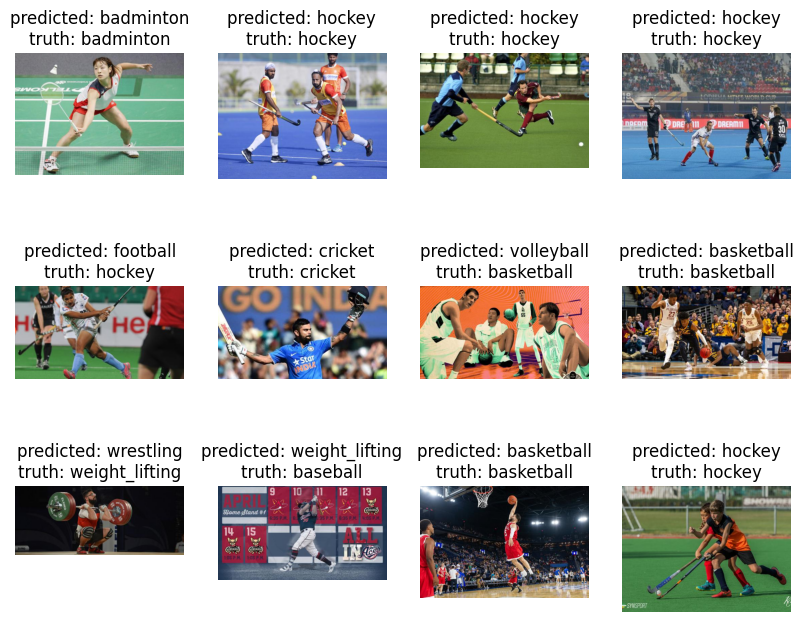

In [68]:
visualize_model(image_paths, X, y, model_opti)

In [42]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('./models/alexnet.pt') # Save